---

# Import Libraries

In this section we import the libraries that will be required to process the data.

The first library is **Pandas**.  
Pandas is an open source, BSD-licensed library, providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [1]:
# Import Pandas to provide DataFrame support
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

font = {'size'   : 12}
mpl.rc('font', **font)

In [30]:
# Use Folium to display the Maps for Visualisation
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from folium import plugins

---

# Import and process the Chicago Crime DataSet
This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago in the last year, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, addresses are shown at the block level only and specific locations are not identified.

| Column Name   | Type          | Description                                            | 
| :------------ | :------------ | :----------------------------------------------------- | 
| CASE#         | Plain Text    | The Chicago Police Department RD Number (Records Division Number), which is unique to the incident. | 
| DATE OF OCCURRENCE | Date & Time   | Date when the incident occurred. this is sometimes a best estimate. |
| BLOCK	        | Plain Text    | The partially redacted address where the incident occurred, placing it on the same block as the actual address. |
| IUCR	        | Plain Text    | The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e. |
| PRIMARY DESCRIPTION   | Plain Text    | The primary description of the IUCR code. |
| SECONDARY DESCRIPTION	| Plain Text    | The secondary description of the IUCR code, a subcategory of the primary description. |
| LOCATION DESCRIPTION | Plain Text | Description of the location where the incident occurred. |
| ARREST        | Plain Text    | Indicates whether an arrest was made. |
| DOMESTIC      | Plain Text    | Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act. |
| BEAT          | Plain Text    | Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74. |
| WARD	        | Number        | The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76. |
| FBI CD        | Plain Text    | Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html. |
| X COORDINATE	| Plain Text    | The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block. |
| Y COORDINATE	| Plain Text    | The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LATITUDE	    | Number        | The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LONGITUDE	    | Number        | The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block. |
| LOCATION	    | Location      | The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block. |
	




### Import the 2018 DataSet

The full dataset, 2001 to 2018 contains over 6.7M rows. This makes processing the dataset difficult and time consuming. Only the 2018 data, 187222 records, will be used. In addition, the following clean-up steps are required:
1. Not all of the columns are required. The following columns are removed:
    1. IUCR
    1. ARREST
    1. DOMESTIC
    1. BEAT
    1. WARD
    1. FBI CD
    1. X COORDINATE
    1. Y COORDINATE
    1. LOCATION

In [3]:
# These are the columns that we want to keep.
# Columns not listed here won't be imported, speeding things up.
crime_keep_columns = ['CASE#',
                      'DATE  OF OCCURRENCE',
                      'BLOCK', 
                      ' PRIMARY DESCRIPTION',
                      'LATITUDE',
                      'LONGITUDE']

# Download csv
# !wget -O crimes.csv https://data.cityofchicago.org/api/views/x2n5-8w5q/rows.csv?accessType=DOWNLOAD

# Read from local
df = pd.read_csv('crimes.csv',
                 usecols=crime_keep_columns)

Looking at the Shape of df we can see that only 12 columns have been imported instead of all 22.

In [4]:
df.shape

(264272, 6)

Let's have a quick look at the Head of the imported data

In [5]:
df.head()

,CASE#,DATE OF OCCURRENCE,BLOCK,PRIMARY DESCRIPTION,LATITUDE,LONGITUDE
0,JB241987,04/28/2018 10:05:00 PM,009XX N LONG AVE,NARCOTICS,41.897895,-87.760744
1,JB241350,04/28/2018 08:00:00 AM,008XX E 53RD ST,CRIMINAL DAMAGE,41.798635,-87.604823
2,JB245397,04/28/2018 09:00:00 AM,062XX S MICHIGAN AVE,THEFT,41.780946,-87.621995
3,JB241444,04/28/2018 12:15:00 PM,046XX N ELSTON AVE,THEFT,41.965404,-87.736202
4,JB241667,04/28/2018 04:28:00 PM,022XX S KENNETH AVE,ARSON,41.850673,-87.735597


In [6]:
df.tail()

,CASE#,DATE OF OCCURRENCE,BLOCK,PRIMARY DESCRIPTION,LATITUDE,LONGITUDE
264267,JA525920,11/26/2017 02:02:00 PM,081XX S ASHLAND AVE,THEFT,41.746260,-87.663332
264268,JA475906,10/18/2017 01:31:00 PM,048XX N SHERIDAN RD,ASSAULT,41.969326,-87.654826
264269,JA534571,12/03/2017 03:18:00 AM,002XX W 38TH PL,BATTERY,41.824547,-87.633096
264270,JA492228,10/30/2017 04:00:00 PM,072XX S SOUTH SHORE DR,THEFT,41.764728,-87.561272
264271,JA536019,12/02/2017 08:00:00 PM,083XX S INDIANA AVE,CRIMINAL DAMAGE,41.742865,-87.619547


---
### Clean up the data and prepare

The sample data file was downloaded in the middle of September. So half of September of 2017 was missing and half of September 2018 was not yet populated. To simply resolve this the raw data was altered to move the September 2017 dates to September 2018. 

Now that the data has been imported it needs to be cleaned.
1. Move September 2017 dates to September 2018
1. Clean up the column names:
    1. Strip leading & trailing whitespace
    1. Replace multiple spaces with a single space
    1. Remove # characters
    1. Replace spaces with _
    2. Convert to lowercase
1. Change the date of occurance field to a date / time object
1. Add new columns for:
    1. Hour
    1. Day
    1. Month
    1. Year
    1. etc.
1. Split Block into zip_code and street
1. Verify that all rows have valid data

In [7]:
# Strip leading & trailing whitespace
df.columns = df.columns.str.strip()

# Replace multiple spaces with a single space
df.columns = df.columns.str.replace('\s{2,}', ' ')

# Replace # with blank
df.columns = df.columns.str.replace('#', '')

# Replace spaces with _
df.columns = df.columns.str.replace(' ', '_')

# Convert to lowercase
df.columns = df.columns.str.lower()

# Move September 2017 dates to September 2018
df.date_of_occurrence.replace(to_replace="(09/\\d+)/2017", value=r"\1/2018", regex=True, inplace=True)

In [8]:
df.dtypes

case                    object
date_of_occurrence      object
block                   object
primary_description     object
latitude               float64
longitude              float64
dtype: object

Change the date of occurance field to a date / time object

In [9]:
df['date_of_occurrence'] =  pd.to_datetime(df['date_of_occurrence'], format='%m/%d/%Y %I:%M:%S %p')

Add new columns for the hour, day, month and year of the crime:
1. Hour
1. Day Name
1. Day of week (Tuesday is the first day)
1. Month Name
1. Month Number
1. Year
1. Year and Month

In [10]:
df['hour'] = df['date_of_occurrence'].dt.hour
df['day_name'] = df['date_of_occurrence'].dt.day_name()
df['day'] = df['date_of_occurrence'].dt.dayofweek + 1
df['month_name'] = df['date_of_occurrence'].dt.month_name()
df['month'] = df['date_of_occurrence'].dt.month
df['year'] = df['date_of_occurrence'].dt.year
df['year_month'] = df['date_of_occurrence'].dt.to_period('M')

Split Block into zip_code and street

In [11]:
df['zip'] = df.block.str.split(' ').str[0]
df['street'] = df.block.str.split(' ').str[1:].apply(', '.join)

Verify that all rows have valid data

In [12]:
df.isna().sum()

case                      0
date_of_occurrence        0
block                     0
primary_description       0
latitude               2318
longitude              2318
hour                      0
day_name                  0
day                       0
month_name                0
month                     0
year                      0
year_month                0
zip                       0
street                    0
dtype: int64

In [13]:
df.dropna(inplace=True)
df.reindex()
df.head()

,case,date_of_occurrence,block,primary_description,latitude,longitude,hour,day_name,day,month_name,month,year,year_month,zip,street
0,JB241987,2018-04-28 22:05:00,009XX N LONG AVE,NARCOTICS,41.897895,-87.760744,22,Saturday,6,April,4,2018,2018-04,009XX,"N, LONG, AVE"
1,JB241350,2018-04-28 08:00:00,008XX E 53RD ST,CRIMINAL DAMAGE,41.798635,-87.604823,8,Saturday,6,April,4,2018,2018-04,008XX,"E, 53RD, ST"
2,JB245397,2018-04-28 09:00:00,062XX S MICHIGAN AVE,THEFT,41.780946,-87.621995,9,Saturday,6,April,4,2018,2018-04,062XX,"S, MICHIGAN, AVE"
3,JB241444,2018-04-28 12:15:00,046XX N ELSTON AVE,THEFT,41.965404,-87.736202,12,Saturday,6,April,4,2018,2018-04,046XX,"N, ELSTON, AVE"
4,JB241667,2018-04-28 16:28:00,022XX S KENNETH AVE,ARSON,41.850673,-87.735597,16,Saturday,6,April,4,2018,2018-04,022XX,"S, KENNETH, AVE"


The data is now ready for visualisation.

---
# Data Visualisation

To get a better understanding of the data we will now visualise it.

### Number of Crimes per month

Text(0,1,'Count of Cases Per Month')

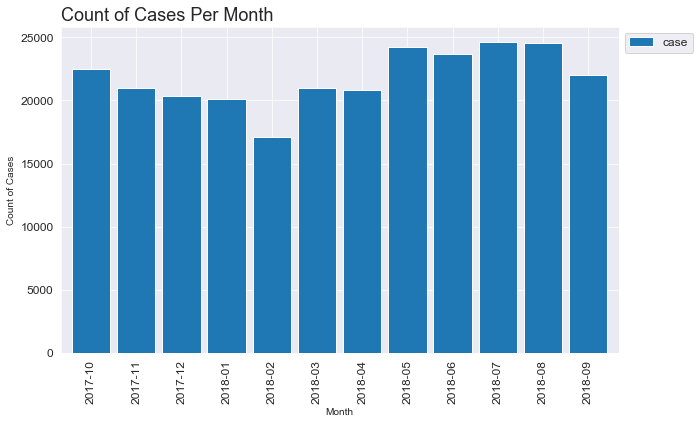

In [14]:
df.groupby('year_month').count().plot(y = 'case', 
                                      kind='bar',
                                      figsize=(10,6),
                                      width=0.85,
                                      fontsize=12,
                                      colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                               prop={'size': 12})

plt.xlabel('Month')
plt.ylabel('Count of Cases')
plt.title('Count of Cases Per Month', loc='left', fontsize=18)

Unsuprisingly there little obvious variation in the number of crimes committed per month other than an apparent drop-off in February. 

### Number of crimes occuring on each day

Text(0,1,'Count of Cases Per Day of Week [1 is a Tuesday]')

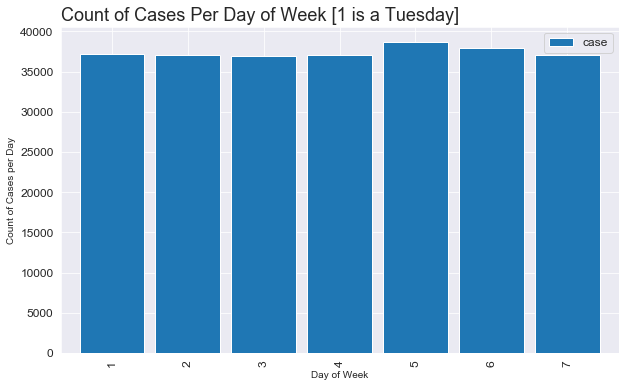

In [15]:
df.groupby('day').count().plot(y = 'case',
                               kind='bar',
                               figsize=(10,6),
                               width=0.85,
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

plt.xlabel('Day of Week')
plt.ylabel('Count of Cases per Day')
plt.title('Count of Cases Per Day of Week [1 is a Tuesday]', loc='left', fontsize=18)

There is a small increase in crime reported at the weekend, Saturday and Sunday, but nothing that couldbe considered significant.

### Number of crimes occuring in each hour

Text(0,1,'Count of Cases Per Hour]')

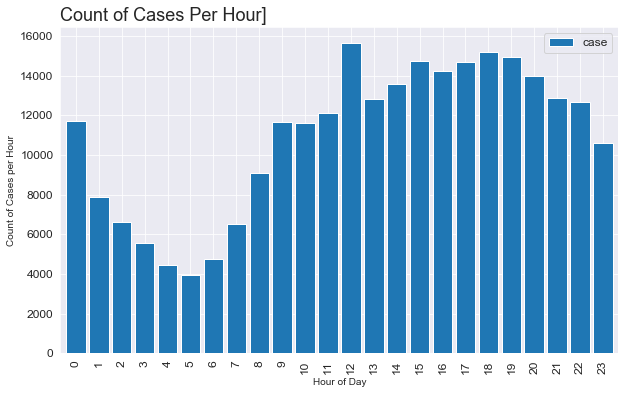

In [16]:
df.groupby('hour').count().plot(y = 'case',
                               kind='bar',
                               figsize=(10,6),
                               width=0.85,
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

plt.xlabel('Hour of Day')
plt.ylabel('Count of Cases per Hour')
plt.title('Count of Cases Per Hour]', loc='left', fontsize=18)

There is an expected fall-off in reported crime rates after midnight and before eight in the morning.

Now let's look at the Crime Categories.

In [17]:
# Number of unique Crime categories bases on the Primary Description
df.primary_description.nunique()

32

In [18]:
# What Crimes are the 10 most commonly occuring ones 
df[['primary_description', 'case']].groupby(
    ['primary_description'], as_index=False).count().sort_values('case', ascending=False).head(10)

,primary_description,case
30,THEFT,63629
2,BATTERY,49499
6,CRIMINAL DAMAGE,27980
1,ASSAULT,19910
8,DECEPTIVE PRACTICE,17492
23,OTHER OFFENSE,16497
3,BURGLARY,12017
17,NARCOTICS,11811
27,ROBBERY,10611
16,MOTOR VEHICLE THEFT,10412


In [19]:
# Create a list of the 10 most commonly occuring crimes
top_crimes = df[['primary_description', 'case']].groupby(
    ['primary_description']).count().sort_values('case', ascending=False)[:10].axes[0].tolist()

top_crimes

['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'ASSAULT',
 'DECEPTIVE PRACTICE',
 'OTHER OFFENSE',
 'BURGLARY',
 'NARCOTICS',
 'ROBBERY',
 'MOTOR VEHICLE THEFT']

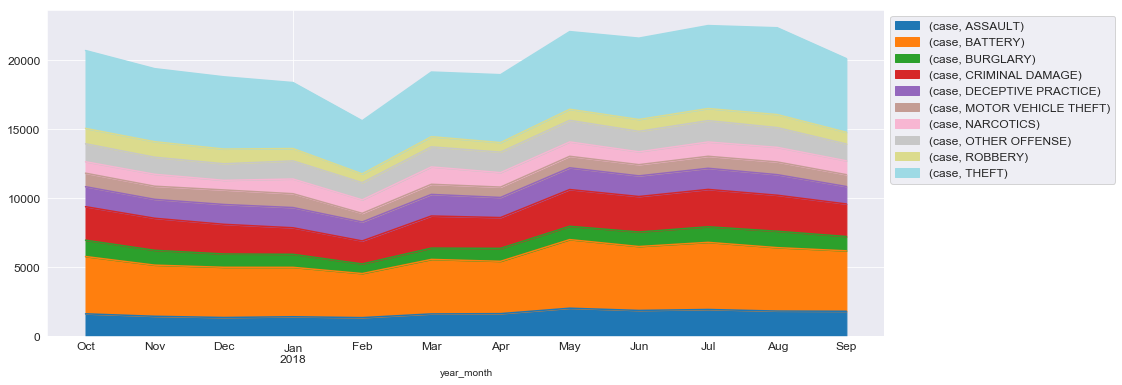

In [20]:
# Create a new data frame with just the top 10 crimes
df_top_crimes = df[df['primary_description'].isin(top_crimes)].copy()

df_top_crimes[['case', 'primary_description', 'year_month']].pivot_table(
    index='year_month', 
    columns='primary_description', 
    fill_value=0, 
    aggfunc='count').plot(kind='area',
                          stacked=True,
                          figsize=(15, 6),
                               fontsize=12,
                               colormap='tab20').legend(bbox_to_anchor=(1,1),
                                                        prop={'size': 12})

### Visual Crimes on map of Chicago

In [42]:
df_top_crimes.dtypes

case                           object
date_of_occurrence     datetime64[ns]
block                          object
primary_description            object
latitude                      float64
longitude                     float64
hour                            int64
day_name                       object
day                             int64
month_name                     object
month                           int64
year                            int64
year_month                     object
zip                            object
street                         object
dtype: object

In [ ]:
### Create a folium map with a different colour per crime

Colour each of the top 10 crimes with a different and plot on a Folium map.

In [27]:
# Create a list of colours. 
# We have  list of the top 10 crimes from earlier
colors = [
    'red',
    'blue',
    'gray',
    'orange',
    'beige',
    'green',
    'purple',
    'pink',
    'cadetblue',
    'black'
]

# Create a dictionary of colours to map to the crimes
dict_colours = dict(zip(top_crimes, colors))

# Add the colours colums to the df_top_crimes DataFrame
df_top_crimes['colour'] = df_top_crimes.primary_description.map(dict_colours)

The entire `df_top_crimes` DataFrame contains too many point to disply effeciently using Folium. To combat this we will just use the data from August 2018.

In [35]:
df_top_crimes_august = df_top_crimes[df_top_crimes.month_name == 'August']

In [28]:
# Define Chicago's geolocation coordinates
chicago_latitude = 41.85003  
chicago_longitude = -87.65005

# Define the world map centered around Chicago with a higher zoom level
chicago_map = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=10)

# display world map
chicago_map

# Instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, col in zip(df_top_crimes_august.latitude, 
                         df_top_crimes_august.longitude, 
                         df_top_crimes_august.colour):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=1, # define how big you want the circle markers to be
            color=col,
            fill=True,
            fill_color=col,
            fill_opacity=0.6
        )
    )

# add incidents to map
chicago_map.add_child(incidents)

KeyboardInterrupt: 

In [33]:
mc = MarkerCluster()

# Define the world map centered around Chicago with a higher zoom level
chicago_cluster = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=10)

# display world map
chicago_cluster

#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in df_top_crimes_august.itertuples():
    mc.add_child(folium.Marker(
        location=[row.latitude,  row.longitude],
                 popup=row.primary_description))
 
chicago_cluster.add_child(mc)
chicago_cluster

KeyboardInterrupt: 

In [ ]:
from folium import plugins
from folium.plugins import HeatMap


chicago_heatmat = folium.Map(location=[chicago_latitude, chicago_longitude], zoom_start=10) 

# List comprehension to make out list of lists
heat_data = [[row['latitude'], 
              row['longitude']] for index, row in df_top_crimes_august.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(chicago_heatmat, 
                          min_opacity=0.5, 
                          max_zoom=18, 
                          max_val=1.0, 
                          radius=15, 
                          blur=10, 
                          gradient=None, 
                          overlay=True)

# Display the map
chicago_heatmat